In [5]:
import numpy as np
import logging
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

try:
  import user_project_config as conf
except:
  import project_config as conf

from IO import data_loading as dl
from utils import logg 
from utils import data_processing as dp
from models_utils import models_utils as mu


from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier

import xgboost as xgb #!!!

In [48]:
import sklearn
sklearn.__version__

'0.17'

In [7]:
#!!!
USED_EXAMPLES_NUMBER = None # 'None' means that all examples are used; otherwise randomly selected

#!!!
OBJECTIVE_NAME = 'cl_sleep_interval' # e.g. 'BMIgr', 'Sex', 'cl_sleep_interval' #!!!!
sample_name = OBJECTIVE_NAME + '_3' # train-test filename
SEED = 0


classifiers = [
  ("XGBoost", xgb.XGBClassifier()),
  ("Dummy", DummyClassifier(strategy='stratified')), # see http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html
  # ("Linear SVM", SVC(kernel="linear", C=0.025)),
  # ("RBF SVM", SVC(gamma=2, C=1)),
  # ("Decision Tree", DecisionTreeClassifier(max_depth=5)),
  ("Random Forest", RandomForestClassifier(n_estimators=100)),
  ("Nearest Neighbors", KNeighborsClassifier(3)),
  # ("AdaBoost", AdaBoostClassifier()),
  ("Naive Bayes", GaussianNB())
  ] # TODO: xgboost

###############################################################
# Initial configuration
np.random.seed(SEED)

In [99]:
trainX, trainY, testX, testY, sample_info = dl.load_hdf5_sample(sample_name)

print trainX.shape
print len(sample_info['Features names'])
trainX[0]
print sample_info#['Features names']

(327834, 38)
38
{'Filtering params': OrderedDict([('interval type', 'N'), ('interval range', [200.0, 2000.0]), ('successive intervals ration range', None)]), 'path': '../../data/sample/cl_sleep_interval_3.h5', 'Features names': ['maxNN', 'minNN', 'meanNN', 'medianNN', 'SDNN', 'SDA60000NN', 'SD60000NNind', 'NN20', 'pNN20', 'NN50', 'pNN50', 'RMSSD', 'MeanHR', 'sd600000HR', 'HRVti', 'TINN', 'outlier', 'meanSD', 'stdSD', 'aVLF', 'aLF', 'aHF', 'peakVLF', 'peakLF', 'peakHF', 'aTotal', 'pVLF', 'pLF', 'pHF', 'nLF', 'nHF', 'LF/HF', 'poincSD1', 'poincSD2', 'sampen', 'alpha0', 'alpha1', 'alpha2'], 'Objective classes names': {0.0: 'awake', 1.0: 'sleep'}, 'Features params': {'time features': {'step sdHR': [600000], 'threshold outlier': 0.2, 'step SDNNind': [60000], 'step SDANN': [60000], 'threshold NN': [20, 50]}, 'nonlinear features': {'embedding dimension': 3, 'tolerance': 0.1, 'alpha border': 16.5, 'box lengths': [4, 6, 8, 10, 12, 14, 16, 17, 25, 33, 41, 49, 57, 64], 'limit for sample size': 420

In [100]:
trainX.shape[0] + testX.shape[0]


#print np.any(np.isnan(trainX[:, 13])==False)
sample_info['Features names'][13]

nans_counter = np.sum(np.isnan(trainX[:, :]), axis=0)
#np.array(sample_info['Features names'])[ind]
ind = nans_counter == 0

#print np.sum(np.isnan(testX[:, :]), axis=0)
nans_counter

array([     0,      0,      0,      0,      0,    403,    403,      0,
            0,      0,      0,      0,      0, 327834,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,  77478,      0,      0,      0])

In [8]:
clf = xgb.XGBClassifier()
clf.fit(trainX, trainY)

/home/iv/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [15]:
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score
predictions = clf.predict(testX)
actuals = testY
cm = confusion_matrix(actuals, predictions)
print(cm)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)
print 'accuracy', accuracy_score(actuals, predictions)

[[78990 13478]
 [13770 33323]]
[[ 0.85424147  0.14575853]
 [ 0.29240014  0.70759986]]
accuracy 0.804759209235


In [67]:
# Recursive Feature Elimination
from sklearn import datasets
from sklearn.feature_selection import RFE


clf = RandomForestClassifier(n_estimators=100) #xgb.XGBClassifier()

rfe = RFE(clf, 5, verbose=1)
rfe = rfe.fit(trainX[:, ind], trainY)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False  True  True False False False False False False  True False
 False False False False  True False False False False False  True False
 False False False False False False False False False False]
[ 9  6  1  1 14 23 12 26 20 17  1  4 15 27  2 16  1  5  8 30 29 28  1 11 24
 22 18 25 19  3 21 10 13  7]


/home/iv/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [74]:
clf = rfe
clf

RFE(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
  estimator_params=None, n_features_to_select=5, step=1, verbose=0)

Automatically created module for IPython interactive environment


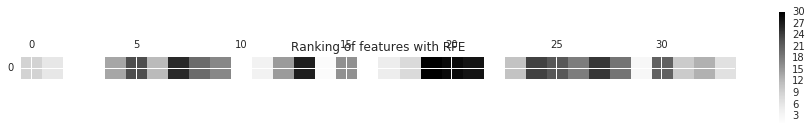

In [89]:
print(__doc__)

from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn


ranking = rfe.ranking_
ranking = ranking[np.newaxis, :]

# Plot pixel ranking
plt.matshow(ranking)
plt.colorbar()
plt.title("Ranking of features with RFE")
plt.show()

In [83]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

AttributeError: 'RFE' object has no attribute 'grid_scores_'

In [81]:
importance = '9  6  1  1 14 23 12 26 20 17  1  4 15 27  2 16  1  5  8 30 29 28  1 11 24  22 18 25 19  3 21 10 13  7'.split(' ')
importance = [int(el) for el in importance if el!='']
importance = np.array(importance)
importance

array([ 9,  6,  1,  1, 14, 23, 12, 26, 20, 17,  1,  4, 15, 27,  2, 16,  1,
        5,  8, 30, 29, 28,  1, 11, 24, 22, 18, 25, 19,  3, 21, 10, 13,  7])

In [73]:
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score

def show_results(clf, testX, testY):
    predictions = clf.predict(testX)
    actuals = testY
    cm = confusion_matrix(actuals, predictions)
    print(cm)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm_normalized)
    print 'accuracy', accuracy_score(actuals, predictions)
    
    
show_results(clf, testX[:, ind], testY)

[[77482 14986]
 [15898 31195]]
[[ 0.83793312  0.16206688]
 [ 0.33758733  0.66241267]]
accuracy 0.778706085511


In [ ]:
np.any(np.isnan(trainX[:, ~ind]))
ind
trainX[:, ind].shape, trainY[ind].shape

In [90]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(trainX[:, ind], trainY)
# display the relative importance of each attribute
print(model.feature_importances_)

ETC_imp = model.feature_importances_

[  4.33715129e-02   6.73588989e-02   7.42422542e-02   8.49738910e-02
   2.34733853e-02   2.84421790e-02   4.48385080e-02   1.98630169e-02
   2.30285504e-02   2.07521018e-02   6.22396974e-02   2.59454761e-02
   2.06870745e-02   1.59820171e-02   2.27028220e-02   2.30776429e-02
   4.05664199e-02   2.84409282e-02   1.78083989e-02   7.06161820e-05
   3.61460622e-03   6.00279995e-03   7.41574387e-02   1.92783623e-02
   1.76928138e-02   1.73425034e-02   1.79019666e-02   1.73982122e-02
   1.77403592e-02   2.81182162e-02   2.12858435e-02   2.35633176e-02
   2.18970554e-02   2.61411134e-02]


/home/iv/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [108]:
sel_ind = ETC_imp > 3 * 10**-2
print sum(sel_ind), 'features'

8 features


In [111]:
clf = RandomForestClassifier(n_estimators=150)#xgb.XGBClassifier()
clf.fit(trainX[:, ind][:, sel_ind], trainY)
show_results(clf, testX[:, ind][:, sel_ind], testY)

[[78448 14020]
 [15210 31883]]
[[ 0.84837998  0.15162002]
 [ 0.32297794  0.67702206]]
accuracy 0.790557533982


/home/iv/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Optimal number of features : 23


/home/iv/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


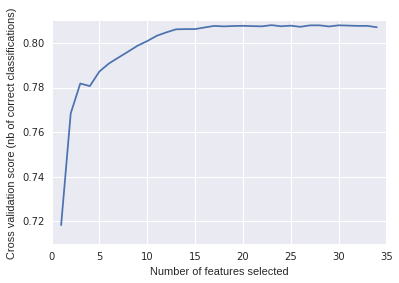

In [113]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

%matplotlib inline

X = trainX[:, ind]
y = trainY
# Create the RFE object and compute a cross-validated score.
svc = RandomForestClassifier(n_estimators=100)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1,scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()